# Inferring reaction constants using ABC

In this notebook, we will simulate a simple enzyme reaction that uses mass-action stochastic kinetics. The objective is to demonstrate and explore the use of ABC techniques to infer the reaction constants of a toy reaction. The notebook begins with a brief introduction and explanation of the simulator model. This is followed by ABC inference using Rejection sampling and BOLFI. The notebook concludes with an analysis of the results.

## Introduction

The simple enzyme-catalysed reaction that we will simulate is as follows:

<img src="https://i.imgur.com/PbPG2Su.png" alt="Reaction image" title="Figure 1" />

The reaction uses the enzyme E to facilitate the conversion of substrate S into product P. C is the intermediate enzyme-substrate complex. c1, c2 and c3 are the three reaction constants that we will infer. We assume that the reaction follows mass-action stochastic kinetics. Mass action describes the behavior of reactants and products in an elementary chemical reaction. Mass action kinetics describes this behavior as an equation where the velocity or rate of a chemical reaction is directly proportional to the concentration of the reactants.
To simulate this reaction, we shall use the popular Gillespie algorithm. The Gillespie algorithm will generate a statistically 'correct' trajectory or a possible solution. We shall avoid going into details and summarise the Gillespie algorithm as performing the following steps:
1. Initialisation
2. Monte Carlo step
3. Update
4. Iterate

Refer to Wikipedia or the book 'Stochastic Modelling for Systems Biology' by Darren J. Wilkinson for a detailed discussion on this. 
For the purposes of this case-study, we shall assume that the intial concentrations are S = 1000 molecules, E = 50 molecules, C = 0 molecules and P = 0 molecules. Also, c1 corresponds to a second order reaction and c2 as well as c3 correspond to a first order reaction. The hazard function in the Gillespie algorithm has been defined accordingly for simplicity. In systems biology, it is common to use Petri nets which are a mathematical framework for modelling reactions. They provide a matrix formalism where the 'Pre' matrix defines the stoichiometry of the reactants, 'Post' matrix defines the stochiometry of the products and 'M' is the initial state of the species involved.

## Model specification

In [1]:
# Import necessary files
import scipy.stats as ss
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import random as rd
import logging
logging.basicConfig(level=logging.INFO)
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

seed = 1
np.random.seed(seed)

import elfi

Create the Gillespie simulator

In [2]:
def gillespie(n_species, n_reactions, Pre, Post, M, c, tspan):
    
    # Function that performs the Gillespie simulation
    
    # Input:
    # n_species - number of species
    # n_reactions - number of reactions
    # Pre - matrix defining the stoichiometry of the reactants
    # Post - matrix defining the stoichiometry of the products
    # M - matrix defining the initial state
    # c - array containing the reactuon constants
    # tspan - array defining the time span
    
    # Output:
    # t - array containing time of simulation
    # x - simulation matrix with n_species rows
    
    S = np.transpose(Post - Pre);
    max_reactions = 100000
    t = np.zeros((1, max_reactions))
    x = np.zeros((n_species, max_reactions))
    # column vector
    current_state = M
    current_time = tspan[0]
    rates = np.zeros((3,1))
    rd.seed(1234)
    for index in range(1,max_reactions+1):
        t[0,index-1] = current_time
        x[:,index-1] = current_state
        rates[0] = c[0] * current_state[0] * current_state[1]
        rates[1] = c[1] * current_state[2]
        rates[2] = c[2] * current_state[2]
        
        current_time = current_time - np.log(rd.random())/(np.sum(rates) + 10e-10)
        if (current_time > tspan[1]):
            break;
        
        arr = np.cumsum(rates)/np.sum(rates)
        rand_num = rd.random()
        reaction = [i for (i, val) in enumerate(arr) if val > rand_num]
        reaction = reaction[0]

        current_state = current_state + S[:, reaction];
    
    t = t[0:index]
    x = x[:,0:index]
    return [t, x]

Create a helper function for the time-span.

In [3]:
def get_time(c1, c2, c3):
    
    # Function that returns the simulation time span
    
    # Input:
    # c1 - reaction constant for the first reaction.
    # c2 - reaction constant for the second reaction.
    # c3 - reaction constant for the third reaction.
    
    # Output:
    # t - array containing time of simulation
    
    c = np.array([c1, c2, c3])
    Pre = np.array([[1, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0]])
    Post = np.array([[0, 0, 1, 0], [1, 1, 0, 0], [0, 1, 0, 1]])
    M = np.array([1000, 50, 0, 0])
    tspan = np.array([0, 200])
    [t, x] = gillespie(4, 3, Pre, Post, M, c, tspan)
    
    return t

Create a wrapper for the simulator so that it can be used by ELFI.

In [4]:
def sim(c1, c2, c3, batch_size=1, random_state=None): 
    
    # Function defining the simulator.
    
    # Input:
    # c1 - reaction constant for the first reaction.
    # c2 - reaction constant for the second reaction.
    # c3 - reaction constant for the third reaction.
    # batch_size - ELFI specific keyword.
    # random_state - ELFI specific keyword.
    
    # Output:
    # x - simulation matrix with n_species rows
    
    c = np.array([c1, c2, c3])
    Pre = np.array([[1, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0]])
    Post = np.array([[0, 0, 1, 0], [1, 1, 0, 0], [0, 1, 0, 1]])
    M = np.array([1000, 50, 0, 0])
    tspan = np.array([0, 200])
    [t, x] = gillespie(4, 3, Pre, Post, M, c, tspan)
    return x

We shall now define prior distributions for the unknown parameters. For simplicitly, we shall just use uniform priors. However, given the nature of this problem more informative priors would give better results. We proceed to create the 'true model' by specifying a set of reaction constants which we try to infer later. Also, the simulator node is generated below.

In [5]:
# create prior nodes
c1 = elfi.Prior('uniform', 0, 2, name='c1')
c2 = elfi.Prior('uniform', 0, 2, name='c2')
c3 = elfi.Prior('uniform', 0, 2, name='c3')

# create the true model by specifying the reaction constants
# that we are trying to infer.
x_obs = sim(0.1, 1, 1)
time = get_time(0.1, 1, 1)

# create the simulator node
X = elfi.Simulator(sim, c1, c2, c3, observed = x_obs)

Below, we visualise the true model.

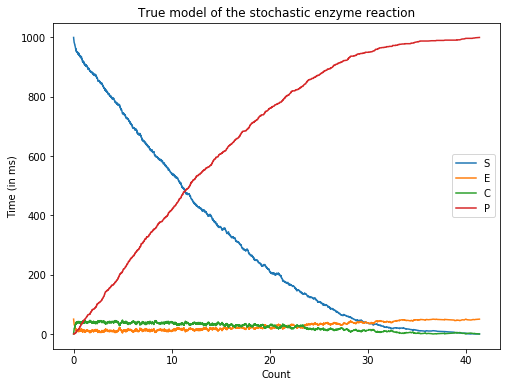

In [6]:
fig = plt.figure(figsize=(8,6))
plt.plot(time[0,0:x_obs.shape[1]], x_obs[0,:], label='S')
plt.plot(time[0,0:x_obs.shape[1]], x_obs[1,:], label='E' )
plt.plot(time[0,0:x_obs.shape[1]], x_obs[2,:], label='C')
plt.plot(time[0,0:x_obs.shape[1]], x_obs[3,:], label='P')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Count')
plt.title('True model of the stochastic enzyme reaction')
plt.show()

For this study, we shall use the auto-covariances with lags 1 and 2 as the summary statistics. A summary statistic is defined for each of the reactants.

In [7]:
# Summary statistic for S
def autocov_1(x, lag=1):
    C = np.mean(x[0,lag:] * x[0,:-lag])
    return C

# Summary statistic for E
def autocov_2(x, lag=1):
    C = np.mean(x[1,lag:] * x[1,:-lag])
    return C

# Summary statistic for C
def autocov_3(x, lag=1):
    C = np.mean(x[2,lag:] * x[2,:-lag])
    return C

# Summary statistic for P
def autocov_4(x, lag=1):
    C = np.mean(x[3,lag:] * x[3,:-lag])
    return C

The functions defined above are used to create the summary nodes.

In [8]:
# create the summary nodes

# summary nodes of S
S1 = elfi.Summary(autocov_1, X, name='S1')
S2 = elfi.Summary(autocov_1, X, 2, name='S2')

# summary nodes of E
S3 = elfi.Summary(autocov_2, X, name='S3')
S4 = elfi.Summary(autocov_2, X, 2, name='S4')

# summary nodes of C
S5 = elfi.Summary(autocov_3, X, name='S5')
S6 = elfi.Summary(autocov_3, X, 2, name='S6')

# summary nodes of P 
S7 = elfi.Summary(autocov_4, X, name='S7')
S8 = elfi.Summary(autocov_4, X, 2, name='S8')

We choose the discrepancy as the common Euclidean L2-distance.

In [9]:
# create the distance node
d = elfi.Distance('euclidean', S1, S2, S3, S4, S5, S6, S7, S8)

We can visualise the inference model as a directed acyclic graph.

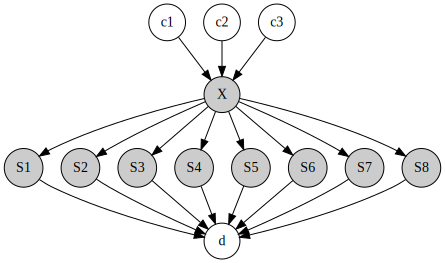

In [10]:
# visualise the inference model
elfi.draw(d)

## Inference with rejection sampling

Now we shall perform inference using rejection sampling. The simplest ABC algorithm samples parameters from their prior distributions, runs the simulator with these and compares them to the observations. The samples are either accepted or rejected depending on how large the distance is. The accepted samples represent samples from the approximate posterior distribution.
This part is time consuming and can take significant amount of time depending on the number of samples drawn. Note: number of samples = N/quantile.

In [9]:
# set up rejectiopn sampling by providing the distance node
rej = elfi.Rejection(d, batch_size=1)

# specify number of samples returned
N = 1000

# note: total number of samples drawn = N/quantile. So in this case,
# 10000 samples are drawn
%time result = rej.sample(N, quantile=0.1)

CPU times: user 34min 12s, sys: 12.3 s, total: 34min 24s
Wall time: 35min 17s


We can view a summary of the results below:

In [20]:
result.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 10000
Threshold: 1.55e+04
Sample means: c1: 0.715, c2: 1.58, c3: 2.05


We can plot the marginal distribution of each of the unknown parameters:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10af47358>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10b93a278>], dtype=object)

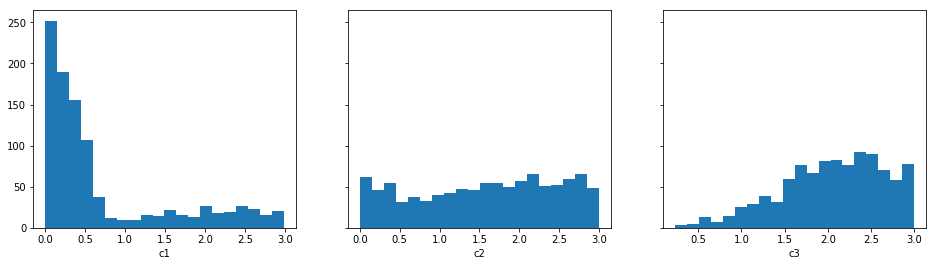

In [21]:
result.plot_marginals()

We can also generate a 3-dimensional scatter plot of the unknown parameter samples:

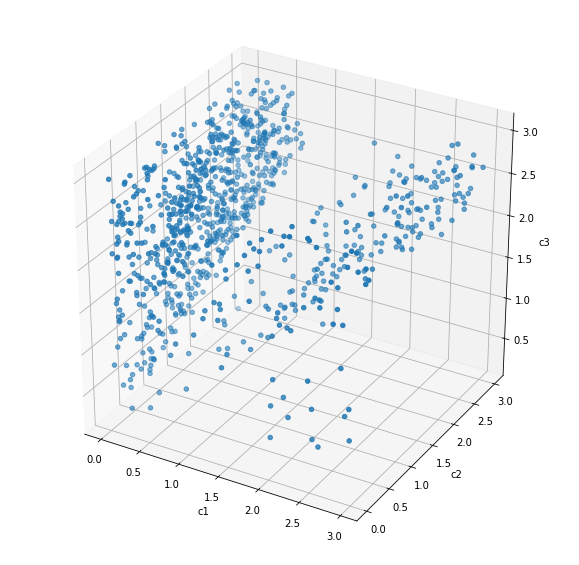

In [22]:
samples = result.samples_array
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:,0], samples[:, 1], samples[:, 2])
ax.set_xlabel('c1')
ax.set_ylabel('c2')
ax.set_zlabel('c3')
plt.show()

Plugging in the inferred reaction constants, we can visualise the reaction model.

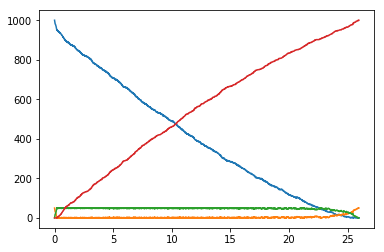

In [23]:
# run Gillespie on inferred value
x_inf = sim(np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:, 2]))
plt.plot(time[0,0:x_inf.shape[1]], x_inf[0,:])
plt.plot(time[0,0:x_inf.shape[1]], x_inf[1,:])
plt.plot(time[0,0:x_inf.shape[1]], x_inf[2,:])
plt.plot(time[0,0:x_inf.shape[1]], x_inf[3,:])
plt.xlabel('Time (in ms)')
plt.ylabel('Count')
plt.show()

## Further analysis with rejection sampling

We can try to improve the inference by drawing 100000 samples instead. We decrease the quantile as well and hence the effective number of samples will be 1000. This takes time and was performed on Triton. Below, we simply load the resulting samples.

In [25]:
# load the ArrayPool which was generated on Triton
# NOTE: replace with generated pool!
arraypool = elfi.ArrayPool.open('arraypool_3731595168')
# re-create the rejection object
rej = elfi.Rejection(d, batch_size=1, pool=arraypool)
N = 1000
# re-create the result object
result = rej.sample(N, quantile=0.01)
result.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 8.01e+03
Sample means: c1: 0.0942, c2: 1.29, c3: 1.32


We can also play around with the Summary statistics. In the next analysis, the summary statistics with lag greater than 1 were removed. That is, we omit S2, S4, S6 and S8. We draw 100000 samples and again run it on Triton as it is time consuming. Below, we simply load the samples.

In [30]:
# NOTE: replace with generated samples file!
samples = np.load('rej_mod_samples.npy')
samples_mean = np.mean(samples, axis=0)
print('Sample means: c1: %f, c2: %f, c3: %f' %(samples_mean[0], samples_mean[1], samples_mean[2]))

Sample means: c1: 0.089351, c2: 1.293059, c3: 1.319681


## Inference with BOLFI

We can begin the inference with BOLFI by first taking the log of the distance:

In [34]:
log_d = elfi.Operation(np.log, d)

Then, the BOLFI inference can be set up

In [35]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=10,
                   bounds={'c1':(0, 2), 'c2':(0, 2), 'c3':(0, 2)}, acq_noise_var=[0.1, 0.1, 0.1], seed=seed)

Below, we fit the surrogate model

In [36]:
%time post = bolfi.fit(n_evidence=100)

INFO:elfi.methods.parameter_inference:BOLFI: Fitting the surrogate model...
INFO:elfi.methods.posteriors:Using optimized minimum value (8.7476) of the GP discrepancy mean function as a threshold


CPU times: user 33 s, sys: 364 ms, total: 33.4 s
Wall time: 33.6 s


Then, we can perform the sampling

In [37]:
%time result_BOLFI = bolfi.sample(1000, info_freq=500)

INFO:elfi.methods.posteriors:Using optimized minimum value (8.7476) of the GP discrepancy mean function as a threshold
INFO:elfi.methods.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Iterations performed: 500/1000...
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.069. After warmup 476 proposals were outside of the region allowed by priors and rejected, decreasing acceptance ratio.
INFO:elfi.methods.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: Iterations performed: 500/1000...
INFO:elfi.methods.mcmc:NUTS: Adaptation/warmup finished. Sampling...
INFO:elfi.methods.mcmc:NUTS: Acceptance ratio: 0.072. After warmup 487 proposals were outside of the region allowed by priors and rejected, decreasing acceptance ratio.
INFO:elfi.methods.mcmc:NUTS: Performing 1000 iterations with 500 adaptation steps.
INFO:elfi.methods.mcmc:NUTS: I

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
c1 33.333569642 1.07869884446
c2 21.9767878884 1.25765969746
c3 138.329642403 1.00809446586
CPU times: user 4min 26s, sys: 33.5 s, total: 5min
Wall time: 4min 29s


We can view a summary of the result below:

In [38]:
result_BOLFI.summary()

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: 8.75
Sample means: c1: 0.63, c2: 0.938, c3: 1.49


We can plot the discrepancy for each of the unknowns:

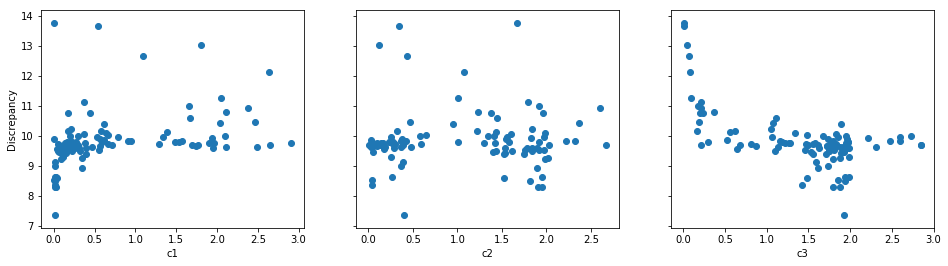

In [40]:
bolfi.plot_discrepancy()
plt.show()

Also, we can visualise the histograms of the unknown parameters that were sampled.

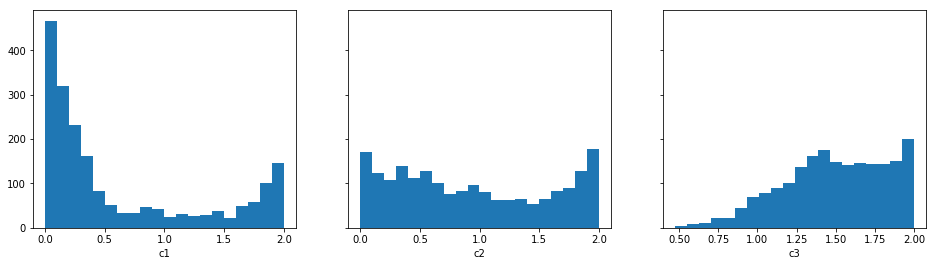

In [41]:
result_BOLFI.plot_marginals()
plt.show()

We can also generate a 3-dimensional scatter plot of the unknown parameter samples:

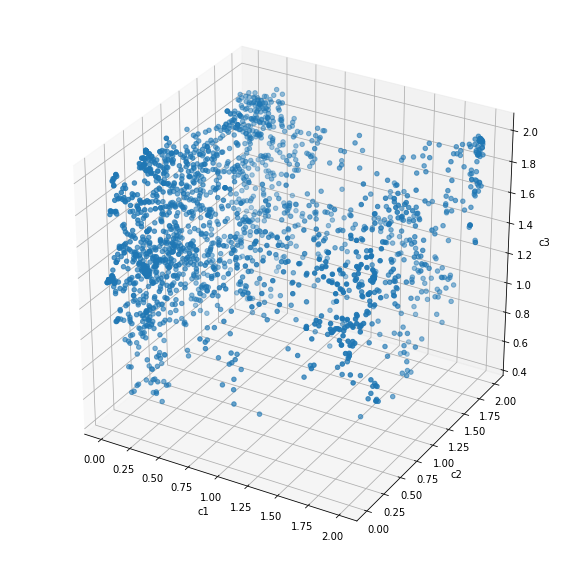

In [42]:
samples = result_BOLFI.samples_array
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:,0], samples[:, 1], samples[:, 2])
ax.set_xlabel('c1')
ax.set_ylabel('c2')
ax.set_zlabel('c3')
plt.show()

Plugging in the inferred reaction constants, we can visualise the reaction model.

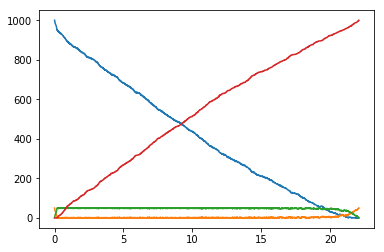

In [43]:
# run Gillespie on inferred value
x_inf = sim(np.mean(samples[:,0]), np.mean(samples[:,1]), np.mean(samples[:, 2]))
plt.plot(time[0,0:x_inf.shape[1]], x_inf[0,:])
plt.plot(time[0,0:x_inf.shape[1]], x_inf[1,:])
plt.plot(time[0,0:x_inf.shape[1]], x_inf[2,:])
plt.plot(time[0,0:x_inf.shape[1]], x_inf[3,:])
plt.xlabel('Time (in ms)')
plt.ylabel('Count')
plt.show()

## Further analysis with BOLFI

We can try to improve the inference by increasing the number of samples per chain to 4000. Also, we can increase the number of evidence points in the surrogate model as well. This takes time and was performed on Triton. Below, we simply load the resulting samples.

In [32]:
# NOTE: replace with generated samples file!
samples = np.load('bolfi_samples.npy')
samples_mean = np.mean(samples, axis=0)
print('Sample means: c1: %f, c2: %f, c3: %f' %(samples_mean[0], samples_mean[1], samples_mean[2]))

Sample means: c1: 0.191276, c2: 1.428071, c3: 1.427412


Similar to rejection sampling, we can also play around with the Summary statistics. In the next analysis, the summary statistics with lag greater than 1 were removed. That is, we omit S2, S4, S6 and S8. We draw 4000 samples per chain and again run it on Triton as it is time consuming. Below, we simply load the samples.

In [33]:
# NOTE: replace with generated samples file!
samples = np.load('bolfi_mod_samples.npy')
samples_mean = np.mean(samples, axis=0)
print('Sample means: c1: %f, c2: %f, c3: %f' %(samples_mean[0], samples_mean[1], samples_mean[2]))

Sample means: c1: 0.761691, c2: 0.959110, c3: 1.314841


## Summary

We have created an inference model using ELFI to infer reaction constants of a simple stochastic enzyme reaction and have compared the results using rejection sampling as well as BOLFI.

From the above two inference techniques, we can see that BOLFI takes significantly less time than rejection sampling and produces comparable (and sometimes better results). The overall accuracy using ABC in inferring the reaction constants may not be very high. However, better results can be obtained by using more samples and using more informative priors. Also, further tuning of experiment settings will yield better results, but this is beyond the scope of this case study and can be done as future work.